# Learner selection

Having analysed and modelled coffee data, it is time to select the approriate Learner for it. 

**Learning objective:** From my analysis I want to select learner, which will most accuratelly fit the data and predict brewing method, focusing on avoiding false positive (could be brand damaging to the client), but also considering false negative (not to miss out on cheaper raw materials).


To chose the learner I take into cosideration the following factors: all my data is labelled categorical text data, and I have only 851 samples after data cleaning and removal of outliers.

Because of small volume of data I will try *SGD Classifier*, which relies on simple stochastic descent learning routine and is easy to implement.
Because of categorical text data I will also test *Naive Bayes*, which works well with small training data, also it is good for combating the curse of dimensionality (though it does not seem to be the problem in my dataset).
Another Classifier I will try is the *KNN*, which works well where the decision boundry is very irregular.
Finally, I am considering *Decistion Trees*, however, their implemention in sklear requires numerical data only, and I will have to encode all of my text variables.

My initial assumption is that Naive Bayes will best correspond to my data, and the problem I am trying to solve.

## Data split

Before I can start testing learners, I need to split my data. I will use random seed 42, to make sure I always get the same randomly divided data.

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [14]:
coffee_df = pd.read_csv('data\coffee_desk_dataset_ead_selected.csv', index_col=0)
coffee_df.head(5)

,origin_region,natural,fermented_traditional,fermented_closed_tank,brewing_method_binary_num
idx,,,,,
1,Latam,True,False,False,1
2,Africa,True,False,False,1
3,Africa,False,False,False,1
4,Asia,True,False,False,1
5,Latam,True,False,False,1


In [16]:
X_df = coffee_df.drop('brewing_method_binary_num', axis=1) # defining predictors
y_df = coffee_df['brewing_method_binary_num'] # defining target variable

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42) #using random state to ensure I always have random division with the same random numbers
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## Data encoding

Since my data is categorical text data, I will encode it with one hot encoder into binary vectors.

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
encoder = OneHotEncoder(handle_unknown="ignore")
encoder.fit(X_train) # all variables are categorical

OneHotEncoder(handle_unknown='ignore')

In [20]:
X_train = encoder.transform(X_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)

## Model selection

Having encoded data (target is already encoded as 1 for specialty brewing and 0 for espresso), I can now proceed to fit different models on my data, and decide which to use as the optimal with possible changes to optimazation and hyperparameters.

In [21]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [35]:
model = CategoricalNB()
X_train_dense = X_train.todense()
X_validation_dense = X_validation.todense()
model.fit(X_train_dense, y_train)
y_train_pred = model.predict(X_train_dense)
y_validation_pred = model.predict(X_validation_dense)

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_validation, y_validation_pred)
tn, fp, fn, tp = cm.ravel()
print(f'True negatives: {tn}')
print(f'True positives: {tp}')
print(f'False negatives: {fn}')
print(f'False positives: {fp}')

True negatives: 28
True positives: 31
False negatives: 12
False positives: 14


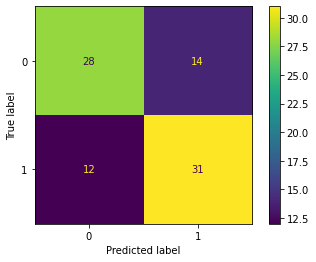

In [40]:
ConfusionMatrixDisplay(cm).plot()

True negatives: 209
True positives: 258
False negatives: 103
False positives: 110


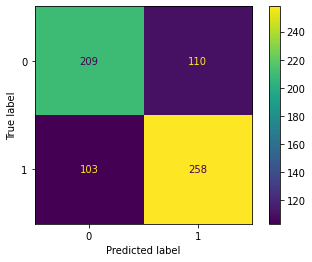

In [41]:
cm = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = cm.ravel()
print(f'True negatives: {tn}')
print(f'True positives: {tp}')
print(f'False negatives: {fn}')
print(f'False positives: {fp}')
ConfusionMatrixDisplay(cm).plot()

In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

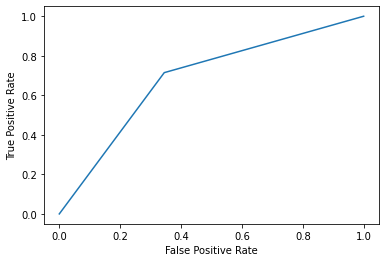

In [44]:
fpr, tpr, _ = roc_curve(y_train, y_train_pred, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [47]:
models = {
    'CategoricalBayes' : CategoricalNB(),
    'SGDClassifier' : SGDClassifier(),
    'KNNs' : KNeighborsClassifier(n_neighbors=9)
}

train_predictions_by_model = {}
validation_predictions_by_model = {}

for name, model in models.items():

    model.fit(X_train_dense, y_train)

    y_train_pred = model.predict(X_train_dense)
    y_validation_pred = model.predict(X_validation_dense)

    train_predictions_by_model[name] = y_train_pred
    validation_predictions_by_model[name] = y_validation_pred


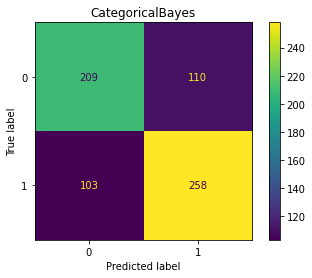

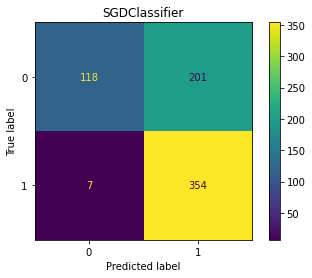

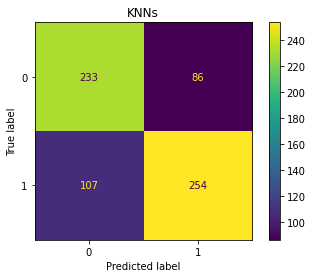

In [52]:
for name, y_train_pred in train_predictions_by_model.items():
    cm = confusion_matrix(y_train, y_train_pred)
    display = ConfusionMatrixDisplay(cm).plot()
    display.ax_.set_title(name)

In [ ]:
#TODO: add roc curve and threshold optimization

# TODO: questions:
# what about naive bayes - there is no threshold, just highet probability decides, I can play around with smoothing

In [ ]:
# setting threshold example

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state = 2)
clf.fit(X_train,y_train)
# y_pred = clf.predict(X_test)  # default threshold is 0.5
y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool) # set threshold as 0.3